In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import yfinance as yf
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load data
start_date = '1800-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
symbol = "AAPL"
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
data["Price Pct Change"] = data["Adj Close"].pct_change()
data["Price Pct Change"] = data["Price Pct Change"].shift(-1)
data["Price Pct Change"] = data["Price Pct Change"].fillna(0)

data["Dollar Volume"] = data["Adj Close"] * data["Volume"]
data["Dollar Volume Pct Change"] = data["Dollar Volume"].pct_change()
data["Dollar Volume Pct Change"] = data["Dollar Volume Pct Change"].shift(-1)

data.head()

,Open,High,Low,Close,Adj Close,Volume,Price Pct Change,Dollar Volume,Dollar Volume Pct Change
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098834,469033600,-0.052170,4.635666e+07,-0.644570
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093678,175884800,-0.073398,1.647657e+07,-0.443000
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086802,105728000,0.024750,9.177448e+06,-0.162180
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.088951,86441600,0.028993,7.689053e+06,-0.125663
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091530,73449600,0.061029,6.722825e+06,-0.297501


In [4]:
#moving average
data["MA5"] = data["Adj Close"].rolling(window=5).mean()
data["MA20"] = data["Adj Close"].rolling(window=20).mean()
data["MA50"] = data["Adj Close"].rolling(window=50).mean()
data["MA200"] = data["Adj Close"].rolling(window=200).mean()

#RSI
data["RSI"] = ta.RSI(data["Adj Close"], timeperiod=14)

#MACD
data["MACD"], data["Signal Line"], data["MACD Histogram"] = ta.MACD(data["Adj Close"], fastperiod=12, slowperiod=26, signalperiod=9)

#Bollinger Bands
data["Upper Band"], data["Middle Band"], data["Lower Band"] = ta.BBANDS(data["Adj Close"], timeperiod=20)

data = data.dropna()

data.head()



,Open,High,Low,Close,Adj Close,Volume,Price Pct Change,Dollar Volume,Dollar Volume Pct Change,MA5,MA20,MA50,MA200,RSI,MACD,Signal Line,MACD Histogram,Upper Band,Middle Band,Lower Band
Date,,,,,,,,,,,,,,,,,,,,
1981-09-28,0.064174,0.064732,0.064174,0.064174,0.049417,91728000,0.052171,4.532942e+06,0.086087,0.053886,0.063684,0.072914,0.090962,19.460676,-0.005966,-0.004878,-0.001088,0.077784,0.063684,0.049584
1981-09-29,0.067522,0.068080,0.067522,0.067522,0.051995,94684800,0.008264,4.923170e+06,-0.467602,0.052683,0.062824,0.072295,0.090728,27.078683,-0.006017,-0.005106,-0.000911,0.077560,0.062824,0.048089
1981-09-30,0.068080,0.068638,0.068080,0.068080,0.052425,49996800,0.000000,2.621085e+06,0.222670,0.051824,0.061772,0.071694,0.090522,28.296035,-0.005954,-0.005275,-0.000678,0.076318,0.061772,0.047225
1981-10-01,0.068080,0.068638,0.068080,0.068080,0.052425,61129600,0.081977,3.204723e+06,-0.202691,0.051050,0.060654,0.071187,0.090350,28.296035,-0.005836,-0.005388,-0.000449,0.074449,0.060654,0.046860
1981-10-02,0.073661,0.074219,0.073661,0.073661,0.056723,45046400,0.030301,2.555154e+06,-0.014272,0.052597,0.059945,0.070723,0.090189,39.928461,-0.005335,-0.005377,0.000042,0.072998,0.059945,0.046893


In [6]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Price Pct Change', 'Dollar Volume', 'Dollar Volume Pct Change', 'MA5',
       'MA20', 'MA50', 'MA200', 'RSI', 'MACD', 'Signal Line', 'MACD Histogram',
       'Upper Band', 'Middle Band', 'Lower Band'],
      dtype='object')

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Use adjusted closing prices
closing_prices = data[['Adj Close']].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Prepare training and testing datasets
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Prepare data for LSTM
look_back = 60  # Number of past days to consider
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict on test data
y_pred_scaled = model.predict(X_test)

# Convert predictions and test data back to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred_scaled)

# Calculate binary labels: Increase (1) or Decrease (0)
# Use previous day's price as threshold
thresholds = y_test_original[:-1]
y_test_binary = (y_test_original[1:] > thresholds).astype(int).flatten()
y_pred_binary = (y_pred_original[1:] > thresholds).astype(int).flatten()

# Compute evaluation metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


/Users/pratikk/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 4.7337e-05
Epoch 2/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 2.8541e-06
Epoch 3/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 2.1451e-06
Epoch 4/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.9115e-06
Epoch 5/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.0702e-06
Epoch 6/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 1.4123e-06
Epoch 7/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.8579e-06
Epoch 8/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.2015e-06
Epoch 9/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.4253e-06
Epoch 10/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.5625e-06
Epoch 11/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.2667e-06
Epoch 12/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 1.2650e-06
Epoch 13/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 1.1969e-06
Epoch 14/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - los

[*********************100%***********************]  1 of 1 completed


/Users/pratikk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pratikk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pratikk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pratikk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
SVM - MAE: 98.83505848606814, RMSE: 117.25954434254892, R²: -2.4565149818485517
Random Forest - MAE: 78.89070123968571, RMSE: 100.98877469769357, R²: -1.5638242144368841
ARIMA - MAE: 78.85938297366138, RMSE: 100.96336838743721, R²: -1.5625343855395482
LSTM - MAE: 20.43688824977255, RMSE: 29.667310688171714, R²: 0.7787422973985143


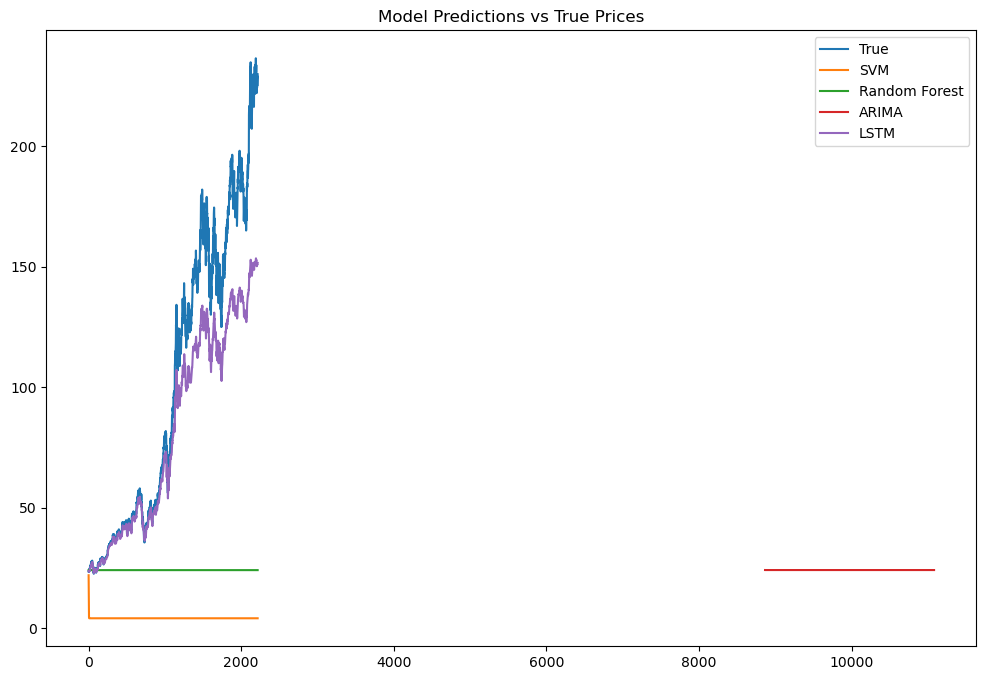

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load data
start_date = '1800-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
symbol = "AAPL"
data = yf.download(symbol, start=start_date, end=end_date)

# Prepare data
data['Date'] = data.index
data = data[['Date', 'Close']].dropna()
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Function to evaluate models
def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return mae, rmse, r2

# SVM Model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
train_svm = np.arange(len(train)).reshape(-1, 1)
test_svm = np.arange(len(train), len(data)).reshape(-1, 1)
svm_model.fit(train_svm, train['Close'])
svm_pred = svm_model.predict(test_svm)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_svm, train['Close'])
rf_pred = rf_model.predict(test_svm)

# ARIMA Model
arima_model = ARIMA(train['Close'], order=(5, 1, 0))
arima_fitted = arima_model.fit()
arima_pred = arima_fitted.forecast(steps=len(test))

# LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Close'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Close'].values.reshape(-1, 1))

X_train = []
y_train = []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

inputs = data['Close'].values[len(data) - len(test) - 60:].reshape(-1, 1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Evaluate and display results
svm_mae, svm_rmse, svm_r2 = evaluate_model(test['Close'], svm_pred)
rf_mae, rf_rmse, rf_r2 = evaluate_model(test['Close'], rf_pred)
arima_mae, arima_rmse, arima_r2 = evaluate_model(test['Close'], arima_pred)
lstm_mae, lstm_rmse, lstm_r2 = evaluate_model(test['Close'], lstm_pred)

print(f"SVM - MAE: {svm_mae}, RMSE: {svm_rmse}, R²: {svm_r2}")
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}, R²: {rf_r2}")
print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}, R²: {arima_r2}")
print(f"LSTM - MAE: {lstm_mae}, RMSE: {lstm_rmse}, R²: {lstm_r2}")

# Plot predictions
plt.figure(figsize=(12, 8))
plt.plot(test['Close'].values, label='True')
plt.plot(svm_pred, label='SVM')
plt.plot(rf_pred, label='Random Forest')
plt.plot(arima_pred, label='ARIMA')
plt.plot(lstm_pred, label='LSTM')
plt.legend()
plt.title("Model Predictions vs True Prices")
plt.show()
